# Dynamic multilayer LSTM-RNN 

To increase the power of our network we can add several layers of LSTM cells using the *MultiRNNCell* function, resulting in a *deep* recurrent neural network. Further, we will add dropout.

In [1]:
% matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Global configuration parameters
n_epochs = 20
total_series_length = 50000
truncated_backprop_steps = 15
echo_step = 3 # number of steps the input is shifted to the right
batch_size = 5
eta = 0.001 # learning rate
n_batches = total_series_length// batch_size//truncated_backprop_steps

# Network parameters
n_hidden = 10 # number of hidden units in each LSTM layer
n_layers = 2 
inp_drop = 1 # dropout input keep probability
out_drop = 1 # dropout output keep probability
n_classes = 2

## Input data

Up to now, our complete training data had the size (5, 10000). Although we will keep these dimensions and also the dimension of the X_placeholder variabe, we will add another dimension to the input when feeding it into the RNN. Before, the batch size was (5,15), i.e. (batch_size, truncated_backprop_steps). Now, for the dynamic rnn the batch size will be (5,15,1).

In [3]:
def generateData():
    """
    Generates training data. The input data is simply a vector of random
    numbers with n_classes classes. The target output is the input shifted 
    by "echo_steps" steps to the right.
    
    Returns:
        x: numpy array of shape (batch_size,-1) filled with random values
        in the range (n_classes)
        
        y: numpy array of shape (batch_size, -1), x shifted "echo_step" to 
        the right
    """

    x = np.array(np.random.choice(n_classes, total_series_length))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))

    return(x, y)

## Network architecture and forward pass

As mentioned before, the shape of the input batches is now (batch_size, truncated_backprop_steps, input_size). Our X_placeholder variable can stay the same but we will insert a dimension of 1 when feeding it into tf.nn.dynamic_rnn. This is done using the function [tf.expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims)

To create multiple layers we call the MultiRNNCell function that takes a list of RNN cells as an input and wraps them into a single cell. 
To further use dropout with MultiRNNCell we wrap the base LSTM cell with dropout. This ensures that dropout is part of each cell passed into the MultiRNNCell function.

In [9]:
X_placeholder = tf.placeholder(tf.float32, shape=[batch_size, truncated_backprop_steps])
y_placeholder = tf.placeholder(tf.int32, shape=[batch_size, truncated_backprop_steps])

# Since we are using several hidden layers, we would have to define a cell 
# state and hidden state for every layer. Therefore, we save the state of 
# the whole network in a tensor. For every layer and every sample in the 
# batch we will have a cell state and a hidden state of size n_hidden
init_state = tf.placeholder(tf.float32, [n_layers, 2, batch_size, n_hidden])

# Since the input to the MultiRNN cell must be a tuple of LSTM tuples, we
# unpack the state tensor.
# First, we unstack the tensor into one 3D tensor per layer 
state_per_layer_list = tf.unstack(init_state, axis=0)

# Then, we create an LSTM tuple for each layer and put all of the LSTM tuples
# into a tuple
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(n_layers)]
)

In [5]:
# For each initialized LSTM cell we need to specify how many hidden
# units the cell should have.
cell = tf.contrib.rnn.LSTMCell(num_units=n_hidden)

# Add dropout
cell = tf.contrib.rnn.DropoutWrapper(cell, 
                                     input_keep_prob=inp_drop, 
                                     output_keep_prob=out_drop)

# Create multiple layers using the MultiRNNCell function
cell = tf.contrib.rnn.MultiRNNCell([cell]*n_layers)

# Create a zero-filled state tensor
#init_state = cell.zero_state(batch_size, tf.float32)

# Create a recurrent neural network specified by "cell", i.e. unroll the
# network.
# Returns a list of all previous RNN hidden states and the final states.
# final_state is now contains three LSTMStateTuple that contain both the 
# final hidden and the cell state of the respective layer.

outputs, final_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(X_placeholder,-1), initial_state=rnn_tuple_state)

# Reshape the outputs and targets such that the logits can be computed 
# using a single matrix multiplication
temp = tf.reshape(outputs, [-1, n_hidden])
y_temp = tf.reshape(y_placeholder, [-1])

# The output of the network is a one-hot encoded vector of predictions.
# When also transforming the target labels into a one-hot encoding (as done
# below), we have to change the loss computation into 
# "tf.nn.softmax_cross_entropy_with_logits"
#y_temp_one_hot = tf.one_hot(y_temp, n_classes)

V = tf.Variable(tf.random_normal([n_hidden, n_classes]))
c = tf.Variable(tf.random_normal([n_classes]))

logits = tf.matmul(temp,V)+c

## Network output and loss function

The predictions of the RNN and the loss are computed in the same way as before.

In [6]:
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_temp_one_hot,
#                                                              logits=l))

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_temp,
                                                             logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(loss)

## Training

In [7]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    training_losses = []
    
    for epoch in range(n_epochs):
        print("")
        print("Epoch: ", epoch)
        
        X_data, y_data = generateData()
        _current_state = np.zeros((n_layers, 2, batch_size, n_hidden))
        
        for batch in range(n_batches):
        
            start_idx = batch*truncated_backprop_steps
            end_idx = start_idx+truncated_backprop_steps
            
            batch_x = X_data[:, start_idx:end_idx]
            batch_y = y_data[:, start_idx:end_idx]

            _total_loss, _optimizer, _current_state = sess.run(
                [loss, optimizer, final_state],
                feed_dict={
                    X_placeholder: batch_x,
                    y_placeholder:batch_y,
                    init_state: _current_state})
            
            training_losses.append(_total_loss)
            
            if batch%100 == 0:
                print("Step: ", batch, "Loss: ", _total_loss)


Epoch:  0
Step:  0 Loss:  0.689573
Step:  100 Loss:  0.668396
Step:  200 Loss:  0.568883
Step:  300 Loss:  0.500575
Step:  400 Loss:  0.434712
Step:  500 Loss:  0.476389
Step:  600 Loss:  0.13591

Epoch:  1
Step:  0 Loss:  0.583608
Step:  100 Loss:  0.0959407
Step:  200 Loss:  0.0188441
Step:  300 Loss:  0.0151491
Step:  400 Loss:  0.00912536
Step:  500 Loss:  0.00844134
Step:  600 Loss:  0.00598813

Epoch:  2
Step:  0 Loss:  0.398901
Step:  100 Loss:  0.00490044
Step:  200 Loss:  0.0029903
Step:  300 Loss:  0.00295215
Step:  400 Loss:  0.00179693
Step:  500 Loss:  0.00205465
Step:  600 Loss:  0.00157947

Epoch:  3
Step:  0 Loss:  0.450208
Step:  100 Loss:  0.0014779
Step:  200 Loss:  0.00123453
Step:  300 Loss:  0.00108328
Step:  400 Loss:  0.00108951
Step:  500 Loss:  0.000942172
Step:  600 Loss:  0.000953409

Epoch:  4
Step:  0 Loss:  0.269758
Step:  100 Loss:  0.000723037
Step:  200 Loss:  0.00077895
Step:  300 Loss:  0.000550912
Step:  400 Loss:  0.000545713
Step:  500 Loss:  0.0

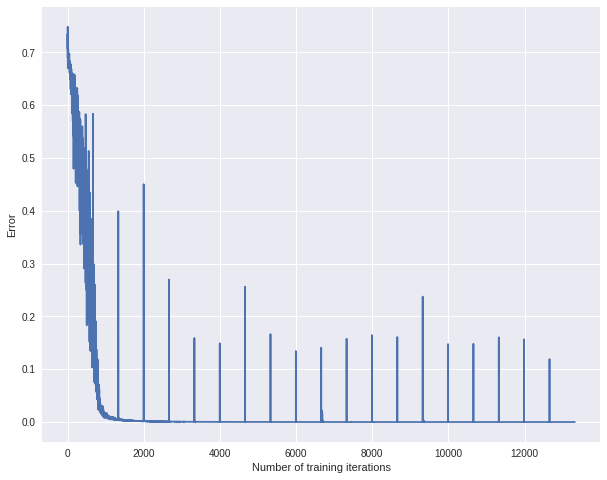

In [8]:
plt.figure(figsize=(10,8));
plt.plot(training_losses);
plt.xlabel('Number of training iterations');
plt.ylabel('Error');